# Feature engineering pipeline and hyperparatuning
#By- Aarush Kumar
#Dated: October 21,2021

In [1]:
!pip install feature-engine

     |████████████████████████████████| 184kB 5.8MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# for the model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import encoding as ce

## Load the data

In [3]:
data = pd.read_csv("/home/aarush100616/Downloads/Projects/Pipeline-and-hyperparam-tuning/Data/train.csv")
data

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [4]:
cols = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
    'Embarked', 'Survived'
]
data = data[cols]
data.head()

Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked  Survived
0       3    male  22.0      1      0   7.2500   NaN        S         0
1       1  female  38.0      1      0  71.2833   C85        C         1
2       3  female  26.0      0      0   7.9250   NaN        S         1
3       1  female  35.0      1      0  53.1000  C123        S         1
4       3    male  35.0      0      0   8.0500   NaN        S         0

In [5]:
data['cabin_num'] = data['Cabin'].str.extract('(\d+)') # captures numerical part
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['Cabin'].str[0] # captures the first letter
data.drop(['Cabin'], axis=1, inplace=True)
data.head()

/home/aarush100616/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/aarush100616/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/aarush100616/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Pclass     Sex   Age  SibSp  Parch     Fare Embarked  Survived  cabin_num  \
0       3    male  22.0      1      0   7.2500        S         0        NaN   
1       1  female  38.0      1      0  71.2833        C         1       85.0   
2       3  female  26.0      0      0   7.9250        S         1        NaN   
3       1  female  35.0      1      0  53.1000        S         1      123.0   
4       3    male  35.0      0      0   8.0500        S         0        NaN   

  cabin_cat  
0       NaN  
1         C  
2       NaN  
3         C  
4       NaN

In [6]:
# numerical: discrete
discrete = [
    var for var in data.columns if data[var].dtype != 'O' and var != 'Survived'
    and data[var].nunique() < 10
]
# numerical: continuous
continuous = [
    var for var in data.columns
    if data[var].dtype != 'O' and var != 'Survived' and var not in discrete
]
# categorical
categorical = [var for var in data.columns if data[var].dtype == 'O']
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))

There are 3 discrete variables
There are 3 continuous variables
There are 3 categorical variables


In [7]:
discrete

['Pclass', 'SibSp', 'Parch']

In [8]:
continuous

['Age', 'Fare', 'cabin_num']

In [9]:
categorical

['Sex', 'Embarked', 'cabin_cat']

In [10]:
# separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Survived', axis=1),  # predictors
    data['Survived'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility
X_train.shape, X_test.shape

((801, 9), (90, 9))

## Set up the pipeline

In [11]:
titanic_pipe = Pipeline([
    # missing data imputation - we replace na in numerical variables
    # with an arbitrary value. 
    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['Age', 'Fare', 'cabin_num'])),
    # for categorical variables, we can either replace na with the string
    # missing or with the most frequent category
    ('imputer_cat',
     mdi.CategoricalImputer(variables=['Embarked', 'cabin_cat'])),
    # categorical encoding - we will group rare categories into 1
    ('encoder_rare_label', ce.RareLabelEncoder(
        tol=0.01,
        n_categories=2,
        variables=['Embarked', 'cabin_cat'],
    )),
    # we replace category names by numbers
    ('categorical_encoder', ce.OrdinalEncoder(
        encoding_method='ordered',
        variables=['cabin_cat', 'Sex', 'Embarked'],
    )),
    # Gradient Boosted machine
    ('gbm', GradientBoostingClassifier(random_state=0))
])

## Grid Search with Cross-validation

In [13]:
param_grid = {
    # try different feature engineering parameters:
    # test different parameters to replace na with numbers
    'imputer_num__arbitrary_number': [-1, 99],
    # test imputation with frequent category or string missing
    'imputer_cat__imputation_method': ['missing','frequent'],
    # test different thresholds to group rare labels
    'encoder_rare_label__tol': [0.1, 0.2],
    # test 2 different encoding strategies
    'categorical_encoder__encoding_method': ['ordered', 'arbitrary'],   
    # try different gradient boosted tree model paramenters
    'gbm__max_depth': [None, 1, 3],
    'gbm__n_estimators': [10, 20, 50, 100, 200]
}

In [14]:
grid_search = GridSearchCV(
    titanic_pipe, # the pipeline
    param_grid, # the hyperparameter space
    cv=3, # the cross-validation
    scoring='roc_auc', # the metric to optimize
)

In [15]:
grid_search.fit(X_train, y_train)

# and we print the best score over the train set
print(("best roc-auc from grid search: %.3f"
       % grid_search.score(X_train, y_train)))

best roc-auc from grid search: 0.972


In [16]:
print(("best linear regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

best linear regression from grid search: 0.886


In [17]:
grid_search.best_estimator_

Pipeline(steps=[('imputer_num',
                 ArbitraryNumberImputer(arbitrary_number=99,
                                        variables=['Age', 'Fare',
                                                   'cabin_num'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['Embarked', 'cabin_cat'])),
                ('encoder_rare_label',
                 RareLabelEncoder(n_categories=2, tol=0.1,
                                  variables=['Embarked', 'cabin_cat'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['cabin_cat', 'Sex', 'Embarked'])),
                ('gbm',
                 GradientBoostingClassifier(n_estimators=200, random_state=0))])

In [18]:
grid_search.best_params_

{'categorical_encoder__encoding_method': 'ordered',
 'encoder_rare_label__tol': 0.1,
 'gbm__max_depth': 3,
 'gbm__n_estimators': 200,
 'imputer_cat__imputation_method': 'missing',
 'imputer_num__arbitrary_number': 99}

In [19]:
results = pd.DataFrame(grid_search.cv_results_)
print(results.shape)
results.head()

(240, 17)


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.331820      0.339217         0.016499        0.004086   
1       0.103843      0.018084         0.017990        0.004637   
2       0.095979      0.005837         0.012722        0.000708   
3       0.101700      0.007260         0.012259        0.000445   
4       0.165601      0.005636         0.013177        0.000574   

  param_categorical_encoder__encoding_method param_encoder_rare_label__tol  \
0                                    ordered                           0.1   
1                                    ordered                           0.1   
2                                    ordered                           0.1   
3                                    ordered                           0.1   
4                                    ordered                           0.1   

  param_gbm__max_depth param_gbm__n_estimators  \
0                 None                      10   
1                 None                      10   
2                 None                      10   
3                 None                      10   
4                 None                      20   

  param_imputer_cat__imputation_method param_imputer_num__arbitrary_number  \
0                              missing                                  -1   
1                              missing                                  99   
2                             frequent                                  -1   
3                             frequent                                  99   
4                              missing                                  -1   

                                              params  split0_test_score  \
0  {'categorical_encoder__encoding_method': 'orde...           0.727007   
1  {'categorical_encoder__encoding_method': 'orde...           0.736580   
2  {'categorical_encoder__encoding_method': 'orde...           0.723876   
3  {'categorical_encoder__encoding_method': 'orde...           0.732166   
4  {'categorical_encoder__encoding_method': 'orde...           0.735566   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.788262           0.789604         0.768291        0.029197   
1           0.803143           0.724174         0.754632        0.034674   
2           0.792467           0.776303         0.764215        0.029278   
3           0.811762           0.728528         0.757485        0.038408   
4           0.808243           0.774395         0.772735        0.029693   

   rank_test_score  
0              232  
1              240  
2              237  
3              239  
4              224

In [20]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
# plot model performance and the generalization error
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)
plt.ylabel('Mean test score - ROC-AUC')
plt.xlabel('Hyperparameter combinations')

Text(0.5, 0, 'Hyperparameter combinations')

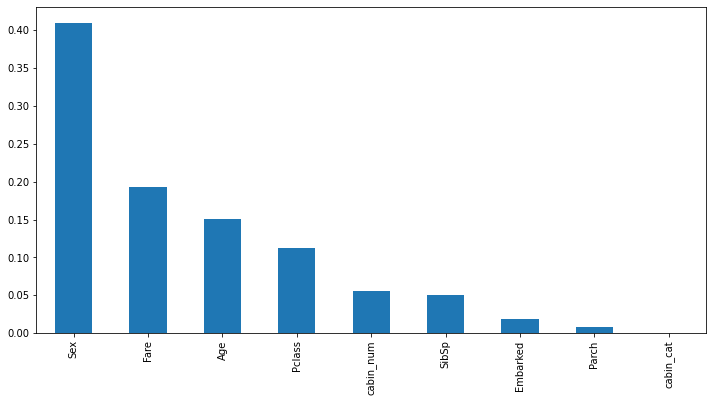

In [21]:
importance = pd.Series(grid_search.best_estimator_['gbm'].feature_importances_)
importance.index = data.drop('Survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))